In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import skimage
import SimpleITK as sitk

image_viewer = sitk.ImageViewer() 

#PARAMETERS

path = "data/04_060__150_00_01_00C_230922_3D.tif"


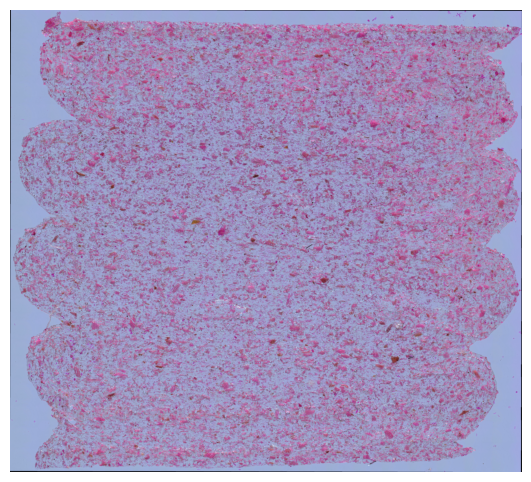

In [11]:
img_color = utils.read_image(path)

img_gray = utils.rgb_to_gray(img_color)
img_gray = sitk.GetImageFromArray(img_gray)
img_gray = sitk.RescaleIntensity(img_gray, 0, 255)


utils.print_image(img_color)

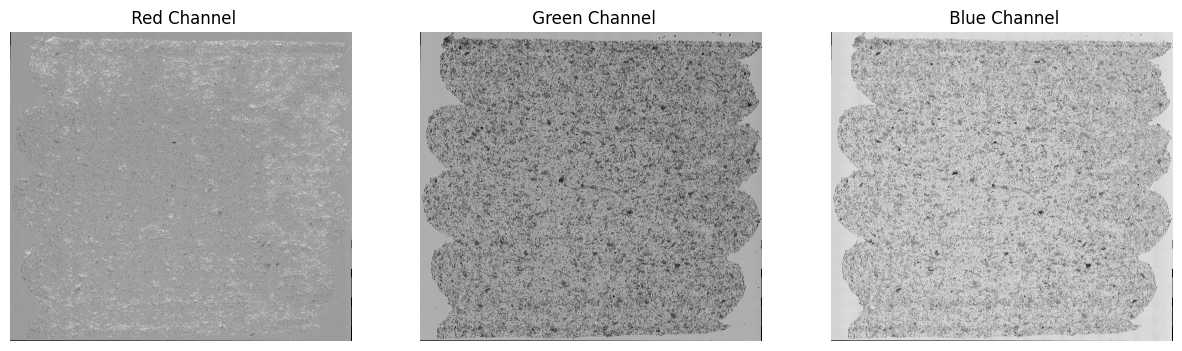

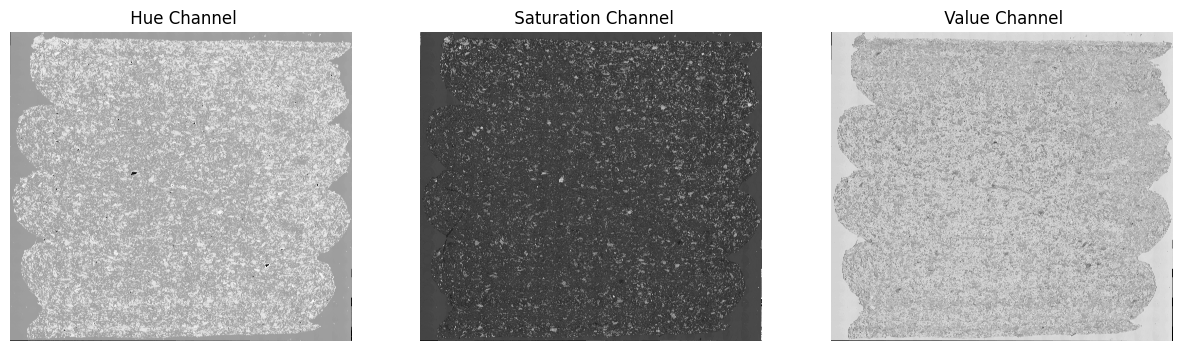

In [3]:
# Print image of each RGB channel
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
rgb_channels = ["Red", "Green", "Blue"]
# for each channel...
for i in range(3):
    # plot channel intensity
    axs[i].imshow(img_color[:, :, i], cmap="gray")
    axs[i].set_title(f" {rgb_channels[i]} Channel")
    axs[i].axis("off")

# create a HSV image from RGB
img_hsv = skimage.color.rgb2hsv(img_color)

# Print image of each HSV channel
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
hsv_channels = ["Hue", "Saturation", "Value"]
# for each channel...
for i in range(3):
    # plot channel intensity
    axs[i].imshow(img_hsv[:, :, i], cmap="gray")
    axs[i].set_title(f" {hsv_channels[i]} Channel")
    axs[i].axis("off")

print;

In [22]:
channel_input = input("Now, pick one channel to explore in more detail (R, G, B, H, S, V")

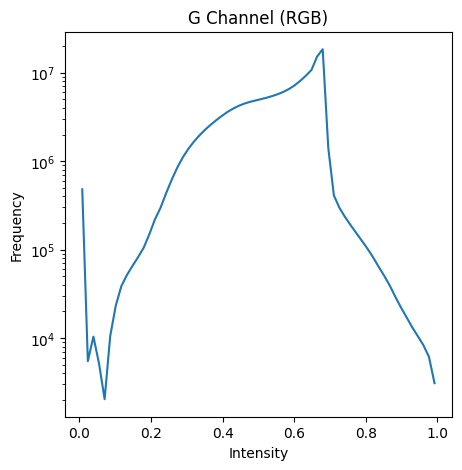

In [23]:
rgb_channels = {'R': 0, 'G': 1, 'B': 2}
hsv_channels = {'H': 0, 'S': 1, 'V': 2}

if channel_input in rgb_channels:
    selected_channel = rgb_channels[channel_input]
    img_data = img_color[:, :, selected_channel]
    channel_type = 'RGB'
elif channel_input in hsv_channels:
    selected_channel = hsv_channels[channel_input]
    img_data = img_hsv[:, :, selected_channel]
    channel_type = 'HSV'
else:
    raise ValueError("Invalid channel selected. Please enter R, G, B, H, S, or V.")

# Plotting the histogram for the selected channel
fig, ax = plt.subplots(figsize=(5, 5))
hist, bins = np.histogram(img_data, bins=64, range=(0.0, 1.0))
lower = (bins[0] + bins[1]) / 2
upper = (bins[-1] + bins[-2]) / 2
pixel_values = np.linspace(lower, upper, len(hist))

ax.plot(pixel_values, hist)
ax.set_yscale('log')
ax.set_xlabel("Intensity")
ax.set_ylabel("Frequency")
ax.set_title(f"{channel_input} Channel ({channel_type})")

plt.show()


In [35]:
import ipywidgets as widgets
from IPython.display import display

def process_image(threshold=0.55):

    global threshold_img

    if channel_input in ['H', 'S', 'V']:
        channel_indices = {'H': 0, 'S': 1, 'V': 2}
        selected_channel_img = img_hsv[:, :, channel_indices[channel_input]]
    else:
        channel_indices = {'R': 0, 'G': 1, 'B': 2}
        selected_channel_img = img_color[:, :, channel_indices[channel_input]]

    # Apply the threshold
    selected_channel_img = (selected_channel_img < threshold).astype(np.uint16)
    selected_channel_img = sitk.GetImageFromArray(selected_channel_img)

    # Display the images
    # utils.print_images([sitk.GetArrayViewFromImage(green_otsu), img_color])
    utils.print_images([sitk.GetArrayViewFromImage(selected_channel_img), img_color])
    threshold_img = selected_channel_img

# Create an interactive slider for the threshold value
widgets.interact(process_image, threshold=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.55))


interactive(children=(FloatSlider(value=0.55, description='threshold', max=1.0, step=0.01), Output()), _dom_cl…

<function __main__.process_image(threshold=0.55)>

In [53]:
#Masks binary image to disregard black text/background from image
binary_mask = sitk.BinaryThreshold(img_gray, lowerThreshold=0, upperThreshold=25, insideValue=0, outsideValue=1)
mask_filter = sitk.MaskImageFilter()
channel_binary = mask_filter.Execute(threshold_img, binary_mask)

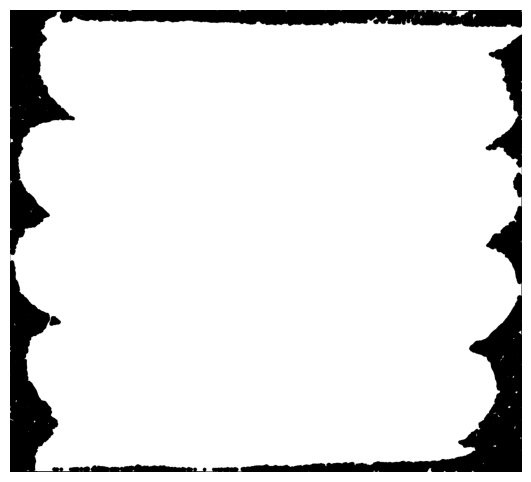

In [54]:
#Closes image
close_filter = sitk.BinaryMorphologicalClosingImageFilter()
close_filter.SetKernelRadius([45, 45])
close_filter.SetForegroundValue(1)

closed_image = close_filter.Execute(channel_binary)

utils.print_image(sitk.GetArrayViewFromImage(closed_image))

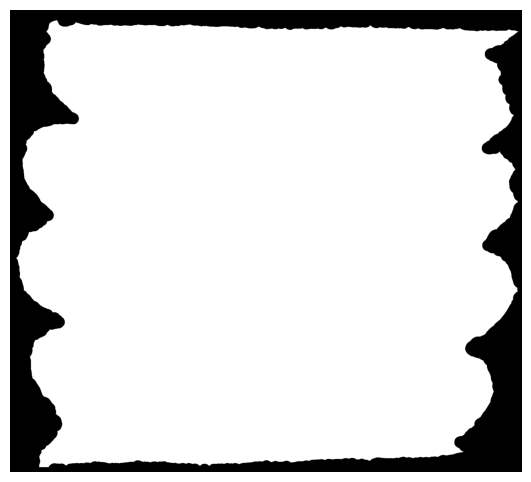

In [49]:
#Erodes image, given that we can afford to lose edge pixels in order to remove background
erode_filter = sitk.BinaryErodeImageFilter()
erode_filter.SetKernelRadius([100, 100])
erode_filter.SetForegroundValue(1)

eroded_image = erode_filter.Execute(closed_image)

utils.print_image(sitk.GetArrayViewFromImage(eroded_image))



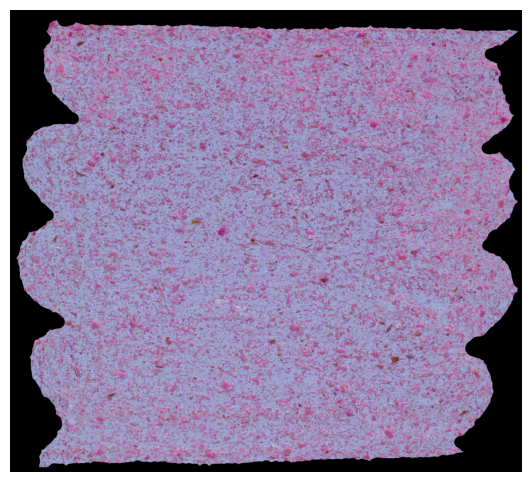

In [50]:
#Appllies a binary mask to the color image, removing background
color_image = sitk.GetImageFromArray(img_color, isVector=True)
mask_image = eroded_image

binary_mask = sitk.BinaryThreshold(mask_image, lowerThreshold=1, upperThreshold=255, insideValue=1, outsideValue=0)

mask_filter = sitk.MaskImageFilter()
mask_filter.SetMaskingValue(0)
masked_color_image = mask_filter.Execute(color_image, binary_mask)

utils.print_image(sitk.GetArrayViewFromImage(masked_color_image))